In [1]:
import pickle
import numpy as np
import pandas as pd

## Load Data

In [2]:
path_subscribers = "C:\\Users\\kongl\\Desktop\\NYU Shanghai\\Fall 2021\\Marketing Analytics\\Final Project\\Fall 2021 MSDABC Final Project\\Digital Marketing Analytics final case project data\subscribers"
path_engagement = "C:\\Users\\kongl\\Desktop\\NYU Shanghai\\Fall 2021\\Marketing Analytics\\Final Project\\Fall 2021 MSDABC Final Project\\Digital Marketing Analytics final case project data\engagement"
path_reps = "C:\\Users\\kongl\\Desktop\\NYU Shanghai\\Fall 2021\\Marketing Analytics\\Final Project\\Fall 2021 MSDABC Final Project\\Digital Marketing Analytics final case project data\customer_service_reps"

In [3]:
# Build a function that loads the binary data

def load_data(path):
    
    '''
    The input of the function is the path of the data file.
    The output of the function is the dataframe loaded.
    '''
    
    f=open(path,"rb")
    df=pickle.load(f)
    f.close()
    
    return df

In [182]:
df_subs = load_data(path_subscribers)
df_eng = load_data(path_engagement)
df_reps = load_data(path_reps)

In [5]:
# Read the channel data

df_channels = pd.read_excel("advertising_spend_data.xlsx", header=2)

## Data Review

First, we check the dataset to see which data we want to use for A/B testing and Allocation method.

In [6]:
rep_customers = df_reps['subid'].unique()
print("In representative dataset, there are records for {} past or present customers.".format(len(rep_customers)))

In representative dataset, there are records for 1369360 past or present customers.


In [7]:
sub_customers = df_subs['subid'].unique()
print("In subsriber dataset, there are records for {} past or present customers.".format(len(sub_customers)))

In subsriber dataset, there are records for 227628 past or present customers.


We're not sure why there are far more customer records in the representative dataset. But merging them might not be a reasonable approach since subids in the subscriber dataset is not a subset of those in the representative dataset.

Let's check the less complex representative dataset first.

We can see that trial plan are for each customer is avialable in this dataset, meaning that representative data might be ideal for our A/B testing.

In [8]:
df_reps['num_trial_days'].value_counts()

14    1968089
7      160596
0       79958
Name: num_trial_days, dtype: int64

Before we start performing A/B testings, we need to find our what are the variants worth testing.<br>
We noticed that the distribution of billing channel is somewhat similar to the distribution of trial plans. <br>
We want to see if it's the case that certain trial plans were only available to certain channels.<br>

In [9]:
# Examine distribution of billing channels

df_reps['billing_channel'].value_counts()

OTT       1848663
itunes     301713
google      58267
Name: billing_channel, dtype: int64

In [10]:
# Examine billing channels with no trial period plans.

df_reps[df_reps['billing_channel'] == 'OTT']['num_trial_days'].value_counts()

14    1826975
0       21688
Name: num_trial_days, dtype: int64

In [11]:
# Examine billing channels with 7-day trial period plans.

df_reps[df_reps['billing_channel'] == 'itunes']['num_trial_days'].value_counts()

7     160596
14    141114
0          3
Name: num_trial_days, dtype: int64

In [12]:
# Examine billing channels with 14-day trial period plans.

df_reps[df_reps['billing_channel'] == 'google']['num_trial_days'].value_counts()

0    58267
Name: num_trial_days, dtype: int64

We can see that what itunes offered were mostly **7-day trials** and **14-day trials**.<br>
Google offered **no trial** period to customers. <br>
OTT offered **14-day trials** and **no trail** plans.


This indicates that we might need to segment customer population when doing the A/B test.<br>
Given the data we had, there are two things we can test: <br>
**14-Day Trial** vs. **7-Day Trial** for itunes customers.<br>
**14-Day Trial** vs. **No Trial** for OTT customers.<br>
<br>
Further hypotheses cannot be tested given the data we had. But in future analysis, we might be also to make some valuable inferences by integrating our two test results with some Diff-in-Diff comparison.

Next, let's check the subscriber data to see how we can extract valuable information for attribution and allocation.

In [13]:
# Build a function that get the account creation month

def get_month(datetime):
    
    '''
    The input of the function is datetime.
    The output of the function is month.
    '''
    
    year, month, date = str(datetime).split('-')
    time = '/'.join([year, month])
    
    return time

In [14]:
# Replace the original date with the recalculated date

df_channels['date'] = df_channels['date'].apply(get_month)
df_subs['account_creation_month'] = df_subs['account_creation_date'].apply(get_month)

In [15]:
df_channels

,date,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral
0,2019/06,84800,75000,17300,21400,11900,10500,5900,6100
1,2019/07,60000,75600,17300,21300,12000,29800,6000,6600
2,2019/08,52300,76100,18100,21300,16300,65900,6200,6800
3,2019/09,49000,75800,18900,21300,16400,73700,6000,7400
4,2019/10,51300,76000,21000,21400,12200,32300,6700,7300
5,2019/11,56100,75900,21400,21600,11700,9800,6300,7300
6,2019/12,51400,76100,32100,22200,12100,3500,7200,8000
7,2020/01,49000,75500,33600,22700,14300,300,6700,7400
8,2020/02,49700,76600,30100,21700,15000,300,6400,6500
9,2020/03,49100,78000,22700,21200,17600,300,5900,10000


In [16]:
# Calculate the budget for each month

df_channels.iloc[:,1:].apply(sum, axis = 1)

0    232900
1    228600
2    263000
3    268500
4    228200
5    210100
6    212600
7    209500
8    206300
9    204800
dtype: int64

In [17]:
# Check the total number of customers converted every month

df_subs['account_creation_month'].value_counts()

2020/02    28089
2019/11    26828
2020/03    26122
2019/07    25708
2019/08    25434
2019/12    25339
2020/01    24843
2019/10    22412
2019/09    20190
2019/06     2663
Name: account_creation_month, dtype: int64

We can confirm that, to calculate attribution and allocation, both subscriber and channel data should be used.<br>
Next, let's think about which data implies conversion.

In [18]:
channels= list(df_channels.columns[1:])
channels

['facebook',
 'email',
 'search',
 'brand sem intent google',
 'affiliate',
 'email_blast',
 'pinterest',
 'referral']

In [19]:
df_paid = df_subs[df_subs['paid_TF'] == True]
df_convert = df_paid[df_paid['refund_after_trial_TF'] == False]

We find it reasonable to consider customers who have made a successful payment and haven't requested refund as converted customers.

In [20]:
df_convert.shape

(82805, 30)

In [21]:
# Check the data we have for attribution

df_convert['attribution_technical'].value_counts()[channels]

facebook                   26279
email                      10007
search                      8095
brand sem intent google     7573
affiliate                   3039
email_blast                 3589
pinterest                   1853
referral                    2797
Name: attribution_technical, dtype: int64

In [22]:
for channel in channels:
    if channel in df_convert['attribution_survey'].value_counts().index:
        print(channel, df_convert['attribution_survey'].value_counts()[channel])

facebook 41142
search 2613
affiliate 639
pinterest 2493
referral 10305


In [23]:
months = sorted(list(df_convert['account_creation_month'].unique()))

In [24]:
df_convert_bymonth = df_convert.groupby("account_creation_month")

In [25]:
df_convert_bymonth.get_group(months[0])['attribution_technical'].value_counts()[channels]

facebook                   497
email                      135
search                      35
brand sem intent google     91
affiliate                   39
email_blast                 61
pinterest                   10
referral                    15
Name: attribution_technical, dtype: int64

In [26]:
df_channels

,date,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral
0,2019/06,84800,75000,17300,21400,11900,10500,5900,6100
1,2019/07,60000,75600,17300,21300,12000,29800,6000,6600
2,2019/08,52300,76100,18100,21300,16300,65900,6200,6800
3,2019/09,49000,75800,18900,21300,16400,73700,6000,7400
4,2019/10,51300,76000,21000,21400,12200,32300,6700,7300
5,2019/11,56100,75900,21400,21600,11700,9800,6300,7300
6,2019/12,51400,76100,32100,22200,12100,3500,7200,8000
7,2020/01,49000,75500,33600,22700,14300,300,6700,7400
8,2020/02,49700,76600,30100,21700,15000,300,6400,6500
9,2020/03,49100,78000,22700,21200,17600,300,5900,10000


There are multiple tasks we can do for attribution and allocation.<br>
First, for attribution method, it's obvious that we shall attribute conversion based on both ***attribution_technical*** and ***attribution_survey***.<br>
Second, we want to calculate CAC for all channels in all months to see if how CAC differs between channels and how CAC of each channel change over time. <br>
Third, using monthly data, we can calculate marginal CAC for allocation decision making. This approach should be viable since monthly budgets for most channels didn't change a lot except channel **email_blast**. This might mean that marginal CAC calculated for email_blast would not be representative.<br>

In [27]:
df_reps.columns

Index(['customer_service_rep_id', 'subid', 'current_sub_TF', 'cancel_date',
       'account_creation_date', 'num_trial_days', 'trial_completed_TF',
       'billing_channel', 'revenue_net_1month', 'payment_period',
       'last_payment', 'next_payment', 'renew'],
      dtype='object')

## A/B Testing

In [28]:
from scipy import stats

In [29]:
# Get the customer population we want to study

df_OTT = df_reps[df_reps['billing_channel'] == 'OTT']
df_itunes = df_reps[df_reps['billing_channel'] == 'itunes']

In [30]:
# Get lists of unique customers for two populations

id_OTT = df_OTT['subid'].unique()
id_itunes = df_itunes['subid'].unique()

First we process and test customers from OTT.

In [31]:
if 1 == 0:
    df_test_OTT = pd.DataFrame(df_OTT.groupby("subid").size()).reset_index()
    df_test_OTT.rename(columns = {0:"conversion"}, inplace = True)
    df_test_OTT.loc[(df_test_OTT['conversion'] == 1),'conversion'] = 0
    df_test_OTT.loc[(df_test_OTT['conversion'] > 1),'conversion'] = 1

In [32]:
if 1 == 0:
    OTT_trials = [list(df_OTT[df_OTT['subid'] == i]['num_trial_days'])[0] for i in id_OTT]

In [33]:
# Write the processed OTT data for A/B testing to csv file

if 1 == 0:
    df_test_OTT['trial_plan'] = OTT_trials
    df_test_OTT.to_csv("df_test_OTT.csv", index = False)

In [34]:
df_test_OTT = pd.read_csv('df_test_OTT.csv')

After processing the data, we start our A/B testing.

In [35]:
df_OTT_0d = df_test_OTT[df_test_OTT['trial_plan'] == 0]
df_OTT_14d = df_test_OTT[df_test_OTT['trial_plan'] == 14]

In [36]:
n1_OTT= len(df_OTT_0d)
n2_OTT = len(df_OTT_14d)
print("The sample sizes for two variant groups are {} and {}. Both are large enough.".format(n1_OTT, n2_OTT))

The sample sizes for two variant groups are 6954 and 1202918. Both are large enough.


In [37]:
p1hat = sum(df_OTT_0d["conversion"])/n1_OTT
p2hat = sum(df_OTT_14d["conversion"])/n2_OTT

In [793]:
p1hat

0.410267471958585

In [794]:
p2hat

0.40814752127742704

Since assumptions of two-sample t test are met, we can conduct a two-sample t test using all data.

Denote by p1, p2 the population conversion rate of no trial and 14-day trial for OTT customers.<br>
Our hypothesis test is: <br>
<br>
H0: p1 - p2 = 0 <br>
Ha: p1 - p2 > 0 ,with a significant rate of 0.05.

To calculate test statistic, we need to know the following parameters: <br>
**p1hat**: Sample conversion rate of no trial. <br>
**p2hat**: Sample conversion rate of 14-day trial. <br>
**pchat**: Combined estimate of population conversion rate <br>
**n1_OTT**: Sample size of no trial group <br>
**n2_OTT**: Sample size of 14-day trial group

In [38]:
# Calculate pchat

pchat = (n1_OTT*p1hat + n2_OTT*p2hat)/(n1_OTT+n2_OTT)
print("The combined estimate of population conversion rate is {}.".format(pchat))

The combined estimate of population conversion rate is 0.4081597061507333.


In [39]:
# Calculate test statistic

z_score = (p1hat - p2hat)/(pchat*(1-pchat)*(1/n1_OTT + 1/n2_OTT))
print("The test statistic is {}.".format(z_score))

The test statistic is 60.67676011979459.


In [40]:
# Calculate the p-value

p_value = stats.norm.sf(abs(z_score))
print("The p-value is {}.".format(p_value))

The p-value is 0.0.


Since our p-value < 0.05, we reject our null hypothesis and conclude that plan without trial had better conversion rate than plan with 14-day trial for OTT customers.

Next we process and test customers from itunes.

In [41]:
if 1 == 0:
    df_test_itunes = pd.DataFrame(df_itunes.groupby("subid").size()).reset_index()
    df_test_itunes.rename(columns = {0:"conversion"}, inplace = True)
    df_test_itunes.loc[(df_test_itunes['conversion'] == 1),'conversion'] = 0
    df_test_itunes.loc[(df_test_itunes['conversion'] > 1),'conversion'] = 1

In [42]:
if 1 == 0:
    itunes_trials = [list(df_itunes[df_itunes['subid'] == i]['num_trial_days'])[0] for i in id_itunes]

In [43]:
# Write the processed OTT data for A/B testing to csv file

if 1 == 0:
    df_test_itunes['trial_plan'] = OTT_trials
    df_test_itunes.to_csv("df_test_itunes.csv", index = False)

In [44]:
df_test_itunes = pd.read_csv('df_test_itunes.csv')
df_test_itunes = df_test_itunes[df_test_itunes['trial_plan'] != 0]

After processing the data, we start our A/B testing.

In [45]:
df_itunes_7d = df_test_itunes[df_test_itunes['trial_plan'] == 7]
df_itunes_14d = df_test_itunes[df_test_itunes['trial_plan'] == 14]

In [46]:
n1_itunes= len(df_itunes_14d)
n2_itunes = len(df_itunes_7d)
print("The sample sizes for two variant groups are {} and {}. Both are large enough.".format(n1_itunes, n2_itunes))

The sample sizes for two variant groups are 78209 and 64043. Both are large enough.


In [47]:
p1hat_2 = sum(df_itunes_14d["conversion"])/n1_itunes
p2hat_2 = sum(df_itunes_7d["conversion"])/n2_itunes

In [797]:
p1hat_2

0.4958380749018655

In [798]:
p2hat_2

0.4931686523117281

Since assumptions of two-sample t test are met, we can conduct a two-sample t test using all data.

Denote by p1, p2 the population conversion rate of no trial and 14-day trial for itunescustomers.<br>
Our hypothesis test is: <br>
<br>
H0: p1 - p2 = 0 <br>
Ha: p1 - p2 > 0 ,with a significant rate of 0.05.

To calculate test statistic, we need to know the following parameters: <br>
**p1hat**: Sample conversion rate of 14-day trial. <br>
**p2hat**: Sample conversion rate of 7-day trial. <br>
**pchat**: Combined estimate of population conversion rate <br>
**n1_itunes**: Sample size of 14-day trial group <br>
**n2_itunes**: Sample size of 7-day trial group

In [48]:
# Calculate pchat

pchat_2 = (n1_itunes*p1hat_2 + n2_itunes*p2hat_2)/(n1_itunes+n2_itunes)
print("The combined estimate of population conversion rate is {}.".format(pchat_2))

The combined estimate of population conversion rate is 0.494636279279026.


In [49]:
# Calculate test statistic

z_score2 = (p1hat_2 - p2hat_2)/(pchat_2*(1-pchat_2)*(1/n1_itunes + 1/n2_itunes))
print("The test statistic is {}.".format(z_score2))

The test statistic is 376.0082057388898.


In [50]:
# Calculate the p-value

p_value2 = stats.norm.sf(abs(z_score2))
print("The p-value is {}.".format(p_value2))

The p-value is 0.0.


Since our p-value < 0.05, we reject our null hypothesis and conclude that plan with 14-day trial had better conversion rate than plan with 7-day trial for itunes customers.

## Attribution and Allocation

In [51]:
from copy import deepcopy

In [52]:
# Compute the credit of each subset and find the total credit for each channel

def count(row, credit):
    
    '''
    The input of the function is one row representing one user.
    The attribution of credit is added to the dictionary named credit.
    '''
    
    attt = row['attribution_technical']
    atts = row['attribution_survey']
    
    if (attt in channels) & (atts in channels):
        credit[attt] += 0.5
        credit[atts] += 0.5
    elif (attt in channels) & (atts not in channels):
        credit[attt] += 1
    elif (attt not in channels) & (atts in channels):
        credit[atts] += 1

In [53]:
# Prepare the dictionary for data storage
credit = dict()
for i in channels:
    credit[i] = 0
    
attribution_bymonth = [deepcopy(credit) for _ in months]

In [54]:
# Compute the attribution for each month each channel

for i,month in enumerate(months):
        df_convert_bymonth.get_group(month).apply(lambda x: count(x,attribution_bymonth[i]),axis=1)
    
# Compute the CAC for each month each channel
CACs = [[0 for _ in channels] for _ in months]
for i in range(len(months)):
    for j,channel in enumerate(channels):
        CACs[i][j] = df_channels.loc[i, channel]/attribution_bymonth[i][channel]
CACs = pd.DataFrame(CACs,columns=channels)
CACs["date"] = months
CACs.set_index("date")

,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral
date,,,,,,,,
2019/06,128.193500,828.729282,443.589744,324.242424,396.666667,241.379310,327.777778,123.232323
2019/07,12.392853,83.031301,45.406824,35.500000,45.197740,61.443299,19.704433,9.880240
2019/08,10.707340,98.383969,30.808511,36.535163,53.618421,122.490706,19.903692,9.103079
2019/09,13.268346,125.289256,34.742647,45.561497,52.480000,146.959123,24.742268,9.261577
2019/10,12.103338,134.751773,33.492823,45.052632,68.539326,105.728314,25.818882,8.716418
2019/11,9.627596,120.763723,30.119634,36.828645,92.490119,47.921760,22.419929,8.079690
2019/12,12.229360,119.185591,32.555781,31.201687,70.760234,28.455285,22.500000,8.810573
2020/01,14.989293,119.179163,28.282828,27.818627,50.709220,22.222222,22.148760,7.640681
2020/02,12.979890,99.545159,24.372470,31.200575,42.857143,13.043478,22.338569,6.509765


Now, we get the amount of CAC for each channel each month.<br>
Given the CACs calculated, **facebook**, **search**, **email_blast**, **pinterest**, and **referral** are more efficient channels.

Next, let's try calculate marginal CAC.

In [55]:
# Store attribution in the dictionary to a dataframe

df_attr = deepcopy(df_channels)
df_attr.drop(columns = 'date', inplace = True)
for i, attribution in enumerate(attribution_bymonth):
    df_attr.loc[i,:] = list(attribution.values())
df_attr['date'] = months

Since data of June 2019 is very different from data of other months, we exclude it in marginal CAC calculation.

In [56]:
df_count = df_attr
df_budget = df_channels

In [57]:
df_count.drop(index = 0, inplace = True)
df_budget.drop(index = 0, inplace = True)

In [58]:
# Build a function that sort and calculate the marginal CAC of each channel

def margin_calculator(channel):
    
    '''
    The input of the function is a channel name.
    The output of the function is a dataframe containing budget, credit, and marginal CAC.
    '''
    
    df_mc = pd.DataFrame()
    df_mc['date'] = df_budget['date']
    df_mc['budget'] = df_budget[channel]
    df_mc['credit'] = df_count[channel]
    
    df_mc.sort_values(by = ['budget', 'credit'], inplace = True)
    df_mc.reset_index(drop = True, inplace = True)
    df_mc['cac'] = df_mc['budget']/df_mc['credit']
    
    # calculate one distance marginal CAC
    list_mc1 = []
    for i in df_mc.index:
        if i == 0:
            mc1 = df_mc.loc[i,'budget']/df_mc.loc[i,'credit']
            list_mc1.append(mc1)
        else:
            mc1 = (df_mc.loc[i,'budget']-df_mc.loc[i-1,'budget'])/(df_mc.loc[i,'credit']-df_mc.loc[i-1,'credit'])
            list_mc1.append(mc1)
    df_mc['marginal_cac_d1'] = list_mc1
    
    # calculate two distance marginal CAC
    list_mc2 = []
    for i in df_mc.index:
        if i in [0,1] :
            mc2 = df_mc.loc[i,'budget']/df_mc.loc[i,'credit']
            list_mc2.append(mc2)
        else:
            mc2 = (df_mc.loc[i,'budget']-df_mc.loc[i-2,'budget'])/(df_mc.loc[i,'credit']-df_mc.loc[i-2,'credit'])
            list_mc2.append(mc2)
    df_mc['marginal_cac_d2'] = list_mc2
    
    # calculate three distance marginal CAC
    list_mc3 = []
    for i in df_mc.index:
        if i in [0,1,2] :
            mc3 = df_mc.loc[i,'budget']/df_mc.loc[i,'credit']
            list_mc3.append(mc3)
        else:
            mc3 = (df_mc.loc[i,'budget']-df_mc.loc[i-3,'budget'])/(df_mc.loc[i,'credit']-df_mc.loc[i-3,'credit'])
            list_mc3.append(mc3)
    df_mc['marginal_cac_d3'] = list_mc3
    
    # Find the highest CAC among all three distances
    
    cacs = ['marginal_cac_d1', 'marginal_cac_d2', 'marginal_cac_d3']
    list_mc = []
    for i in df_mc.index:
        mc = df_mc.loc[i,cacs].max()
        list_mc.append(mc)
    df_mc['marginal_cac'] = list_mc
            
    return df_mc

In [59]:
# Calculate marginal CACs for all channels

marginal_cac = deepcopy(credit)

for channel in channels:
    marginal_cac[channel] = margin_calculator(channel)

Next, let's take a look at marginal CAC's for all channels.<br>
We don't put them all collaborated marginal costs together because what we got here is a very biased estimation of marginal CAC and we need to go back to budgets and credits to see if our marginal CACs are reasonable.

There are several points we want to focus on when looking at marginal CAC for each channel.<br>
First, we want to see if average cac is decreasing as budget goes up.<br>
Second, we want to rely on marginal CAC of distance 1, 2, and 3 to form a general sense of the marginal CAC for this channel. We take the most conservative approach and keep the largest of the three as the marginal CAC.<br>
Third, we want to pay close attention to date. If there is an unorthodox marginal CAC and the data involved in its calculation is from the early month, e.g., 2019/07, the marginal CAC may have little value for us.

In [60]:
print(channels[0])
marginal_cac[channels[0]]

facebook


,date,budget,credit,cac,marginal_cac_d1,marginal_cac_d2,marginal_cac_d3,marginal_cac
0,2020/01,49000,3269.0,14.989293,14.989293,14.989293,14.989293,14.989293
1,2019/09,49000,3693.0,13.268346,0.000000,13.268346,13.268346,13.268346
2,2020/03,49100,3393.5,14.468837,-0.333890,0.803213,14.468837,14.468837
3,2020/02,49700,3829.0,12.979890,1.377727,5.147059,1.250000,5.147059
4,2019/10,51300,4238.5,12.103338,3.907204,2.603550,4.216315,4.216315
5,2019/12,51400,4203.0,12.229360,-2.816901,4.545455,2.841260,4.545455
6,2019/08,52300,4884.5,10.707340,1.320616,1.547988,2.463288,2.463288
7,2019/11,56100,5827.0,9.627596,4.031830,2.894089,3.021719,4.031830
8,2019/07,60000,4841.5,12.392853,-3.957382,-179.069767,13.469068,13.469068


CAC for Facebook is decreasing as budget increases.<br>
Our marginal CAC estimate is also decreasing as budget increases. <br>
We ignore last marginal CAC because it's data from the early month 2019/07.<br>
We don't expect to see increase in marginal CAC if we increase budget above 56000.<br>
Therefore, we might want to allocate more budget on this channel.

In [61]:
print(channels[1])
marginal_cac[channels[1]]

email


,date,budget,credit,cac,marginal_cac_d1,marginal_cac_d2,marginal_cac_d3,marginal_cac
0,2020/01,75500,633.5,119.179163,119.179163,119.179163,119.179163,119.179163
1,2019/07,75600,910.5,83.031301,0.361011,83.031301,83.031301,83.031301
2,2019/09,75800,605.0,125.289256,-0.654664,-10.526316,125.289256,125.289256
3,2019/11,75900,628.5,120.763723,4.255319,-1.063830,-80.000000,4.255319
4,2019/10,76000,564.0,134.751773,-1.550388,-4.878049,-1.154401,-1.154401
5,2019/12,76100,638.5,119.185591,1.342282,20.000000,8.955224,20.000000
6,2019/08,76100,773.5,98.383969,0.000000,0.477327,1.379310,1.379310
7,2020/02,76600,769.5,99.545159,-125.000000,3.816794,2.919708,3.816794
8,2020/03,78000,822.0,94.890511,26.666667,39.175258,10.354223,39.175258


CAC for Email is decreasing as budget increases.<br>
Our marginal CAC estimate seems to be smallest around budget 76000-76100. <br>
But no matter how efficient marginal CACs are, the average CAC is always high.<br>
Therefore, we might want to decrease budget on this channel.

In [62]:
print(channels[2])
marginal_cac[channels[2]]

search


,date,budget,credit,cac,marginal_cac_d1,marginal_cac_d2,marginal_cac_d3,marginal_cac
0,2019/07,17300,381.0,45.406824,45.406824,45.406824,45.406824,45.406824
1,2019/08,18100,587.5,30.808511,3.874092,30.808511,30.808511,30.808511
2,2019/09,18900,544.0,34.742647,-18.390805,9.815951,34.742647,34.742647
3,2019/10,21000,627.0,33.492823,25.301205,73.417722,15.040650,73.417722
4,2019/11,21400,710.5,30.119634,4.790419,15.015015,26.829268,26.829268
5,2020/03,22700,941.0,24.123273,5.639913,5.414013,9.571788,9.571788
6,2020/02,30100,1235.0,24.372470,25.170068,16.587226,14.967105,25.170068
7,2019/12,32100,986.0,32.555781,-8.032129,208.888889,38.838475,208.888889
8,2020/01,33600,1188.0,28.282828,7.425743,-74.468085,44.129555,44.129555


CAC for Search is smallest when budget is between 22700 and 30100.<br>
Our marginal CAC estimate shows the same pattern, with mininal marginal CAC between 21400 and 22700. <br>
This is a strong sign that if we increase budget, we will get greater marginal CAC and the channel would be less efficient.<br>
Therefore, we might want to keep the budget around 22000.

In [63]:
print(channels[3])
marginal_cac[channels[3]]

brand sem intent google


,date,budget,credit,cac,marginal_cac_d1,marginal_cac_d2,marginal_cac_d3,marginal_cac
0,2020/03,21200,521.5,40.651965,40.651965,40.651965,40.651965,40.651965
1,2019/09,21300,467.5,45.561497,-1.851852,45.561497,45.561497,45.561497
2,2019/08,21300,583.0,36.535163,0.000000,1.626016,36.535163,36.535163
3,2019/07,21300,600.0,35.500000,0.000000,0.000000,1.273885,1.273885
4,2019/10,21400,475.0,45.052632,-0.800000,-0.925926,13.333333,13.333333
5,2019/11,21600,586.5,36.828645,1.793722,-22.222222,85.714286,85.714286
6,2020/02,21700,695.5,31.200575,0.917431,1.360544,4.188482,4.188482
7,2019/12,22200,711.5,31.201687,31.250000,4.800000,3.382664,31.250000
8,2020/01,22700,816.0,27.818627,4.784689,8.298755,4.793028,8.298755


CAC for Brand Sem Intent Google shows a general trend of decreasing.<br>
Our marginal CAC estimate shows an unstable pattern. <br>
Although marginal CAC for this channel is confusing, there is evidence that the marginal CAC will remain low if we increase the budget.<br>
Therefore, we might want to increase the budget.

In [64]:
print(channels[4])
marginal_cac[channels[4]]

affiliate


,date,budget,credit,cac,marginal_cac_d1,marginal_cac_d2,marginal_cac_d3,marginal_cac
0,2019/11,11700,126.5,92.490119,92.490119,92.490119,92.490119,92.490119
1,2019/07,12000,265.5,45.197740,2.158273,45.197740,45.197740,45.197740
2,2019/12,12100,171.0,70.760234,-1.058201,8.988764,70.760234,70.760234
3,2019/10,12200,178.0,68.539326,14.285714,-2.285714,9.708738,14.285714
4,2020/01,14300,282.0,50.709220,20.192308,19.819820,139.393939,139.393939
5,2020/02,15000,350.0,42.857143,10.294118,16.279070,16.201117,16.279070
6,2019/08,16300,304.0,53.618421,-28.260870,90.909091,32.539683,90.909091
7,2019/09,16400,312.5,52.480000,11.764706,-37.333333,68.852459,68.852459
8,2020/03,17600,380.0,46.315789,17.777778,17.105263,86.666667,86.666667


CAC for Affilicate starts decreasing and then stay relative constant as budget increases.<br>
Our marginal CAC estimate shows evidence that marginal CAC will remain constant around 5. <br>
Therefore, we might want to increase the budget. How much we want to increase it will be determined by comparison between marginal CACs of channels that worth budget increasing.

In [65]:
print(channels[5])
marginal_cac[channels[5]]

email_blast


,date,budget,credit,cac,marginal_cac_d1,marginal_cac_d2,marginal_cac_d3,marginal_cac
0,2020/01,300,13.5,22.222222,22.222222,22.222222,22.222222,22.222222
1,2020/03,300,17.0,17.647059,0.000000,17.647059,17.647059,17.647059
2,2020/02,300,23.0,13.043478,0.000000,0.000000,13.043478,13.043478
3,2019/12,3500,123.0,28.455285,32.000000,30.188679,29.223744,32.000000
4,2019/11,9800,204.5,47.921760,77.300613,52.341598,50.666667,77.300613
5,2019/07,29800,485.0,61.443299,71.301248,72.651934,63.852814,72.651934
6,2019/10,32300,305.5,105.728314,-13.927577,222.772277,157.808219,222.772277
7,2019/08,65900,538.0,122.490706,144.516129,681.132075,168.215892,681.132075
8,2019/09,73700,501.5,146.959123,-213.698630,211.224490,2660.606061,2660.606061


CAC for Email Blast is increasing as budget increases.<br>
Our marginal CAC estimate tells the same story. <br>
But it's worth noting that this channel's budget was high when the business just started and went low as time went on.<br>
Data from months after 2019/11 informs us that budget over 3500 is definitely not worth the money.<br>
But we can see that CAC and marginal CAC is not very high when budget was around 300.
Therefore, we might want to have a budget between 300 and 3500 for this channel, just to get more data and find the most efficient budget choice around this interval.

In [66]:
print(channels[6])
marginal_cac[channels[6]]

pinterest


,date,budget,credit,cac,marginal_cac_d1,marginal_cac_d2,marginal_cac_d3,marginal_cac
0,2020/03,5900,212.5,27.764706,27.764706,27.764706,27.764706,27.764706
1,2019/09,6000,242.5,24.742268,3.333333,24.742268,24.742268,24.742268
2,2019/07,6000,304.5,19.704433,0.000000,1.086957,19.704433,19.704433
3,2019/08,6200,311.5,19.903692,28.571429,2.898551,3.030303,28.571429
4,2019/11,6300,281.0,22.419929,-3.278689,-12.765957,7.792208,7.792208
5,2020/02,6400,286.5,22.338569,18.181818,-8.000000,-22.222222,18.181818
6,2019/10,6700,259.5,25.818882,-11.111111,-18.604651,-9.615385,-9.615385
7,2020/01,6700,302.5,22.148760,0.000000,18.750000,18.604651,18.750000
8,2019/12,7200,320.0,22.500000,28.571429,8.264463,23.880597,28.571429


CAC for Pinterset remain relatively constant almost all the time.<br>
Our marginal CAC estimate is also very constant around 7. <br>
For Pinterest, it had marginal CAC that almost equals CAC, which is a characteristic not seen in other channels.<br>
We can't tell how the marginal CAC would go if we increase the budget. But it should not change dramatically and is definitely worth trying.
Therefore, we might want to increase the budget, but maybe not by a great amount.

In [805]:
print(channels[7])
marginal_cac[channels[7]]

referral


,date,budget,credit,cac,marginal_cac_d1,marginal_cac_d2,marginal_cac_d3,marginal_cac
0,2020/02,6500,998.5,6.509765,6.509765,6.509765,6.509765,6.509765
1,2019/07,6600,668.0,9.880240,-0.302572,9.880240,9.880240,9.880240
2,2019/08,6800,747.0,9.103079,2.531646,-1.192843,9.103079,9.103079
3,2019/10,7300,837.5,8.716418,5.524862,4.129794,-4.968944,5.524862
4,2019/11,7300,903.5,8.079690,0.000000,3.194888,2.972399,3.194888
5,2019/09,7400,799.0,9.261577,-0.956938,-2.597403,11.538462,11.538462
6,2020/01,7400,968.5,7.640681,0.000000,1.538462,0.763359,1.538462
7,2019/12,8000,908.0,8.810573,-9.917355,5.504587,155.555556,155.555556
8,2020/03,10000,1033.5,9.675859,15.936255,40.000000,11.087420,40.000000


CAC for Referral remain relatively constant around 9.<br>
It's obvious that marginal CAC is still low when the budge increase from 6800 to 7000.<br>
The general budget and credit shows that the effect of this channel varies a lot.<br>
It we take variance into account, we can have a marginal CAC estimate of 5 between 7000 and 10000.<br>
It's hard to tell the trend of these variables since budget differences between different months are too small and the variance of its effect is too large.<br>
We can definitely increase budget over 10000 for more understanding about this channel. But if CAC is our primary objective, a budget between 6000 and 10000 is the safe choice.

Let's summarize everything up and come up with an allocation plan.

In [68]:
# Calculate budgets for previous months to have a budget expectation.

df_channels.apply(lambda x:sum(x[channels]), axis = 1)

1    228600
2    263000
3    268500
4    228200
5    210100
6    212600
7    209500
8    206300
9    204800
dtype: int64

Since our strategy focus on the time period between October and December of year 2021, let's expect budget around 210000.

In [69]:
df_budget

,date,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral
1,2019/07,60000,75600,17300,21300,12000,29800,6000,6600
2,2019/08,52300,76100,18100,21300,16300,65900,6200,6800
3,2019/09,49000,75800,18900,21300,16400,73700,6000,7400
4,2019/10,51300,76000,21000,21400,12200,32300,6700,7300
5,2019/11,56100,75900,21400,21600,11700,9800,6300,7300
6,2019/12,51400,76100,32100,22200,12100,3500,7200,8000
7,2020/01,49000,75500,33600,22700,14300,300,6700,7400
8,2020/02,49700,76600,30100,21700,15000,300,6400,6500
9,2020/03,49100,78000,22700,21200,17600,300,5900,10000


List our expected budge moves here:<br>
**Facebook:** More budget<br>
**Email:** Less budget<br>
**Search:** Keep the budget around 22000<br>
**Brand Sem Intent Google:** More budget<br>
**Affiliate:** More budget<br>
**Email_blast:** Somewhere between 300 and 3500 <br>
**Pinterest:** Increase a little <br>
**Referral:** Somewhere between 6000 and 10000<br>

Our allocation plan will be:<br>
**Facebook:** 80000<br>
**Email:** 43000<br>
**Search:** 22000<br>
**Brand Sem Intent Google:** 30000<br>
**Affiliate:** 18000 <br> 
**Email_blast:** 1000 <br>
**Pinterest:** 8000 <br>
**Referral:** 8000

## Churn Model

We'd like to tell whether a user churned or not and build a model to predict whether users who might churn in the future and use marketing strategies to prevent them from churning.<br>
The first priority is to identify users' churn status.<br>
First, we shall not consider users who didn't even start their subscriptions after free trials since they can't even be considered as converted users.<br>
Therefore, our previous filtered dataframe **df_convert** contains participants that we want to include in our model for training and testing.<br>
Second, variables in **df_convert** can't really tell users who churned from those who didn't. <br>
To determine whether a user churned or not, we need to go to the representative dataset. <br>

In [201]:
# Get lists of id that represent users whose data we are interested in

id_convert = df_convert['subid']
id_reps = df_reps['subid'].unique()
id_eng = df_eng['subid'].unique()
id_joint, convert_ind, reps_ind = np.intersect1d(id_convert, id_reps, return_indices=True)
df_convert_joint = df_convert.iloc[convert_ind]

id_convert = df_convert_joint['subid']
id_joint, convert_ind, eng_ind = np.intersect1d(id_joint, id_eng, return_indices=True)
df_convert_joint = df_convert_joint.iloc[convert_ind]

print('There are a total of {} users that we want to include in our churn model.'.format(len(id_joint)))

There are a total of 53175 users that we want to include in our churn model.


By getting the intersection of **df_convert**, **df_reps**, and **df_eng**, we get a list of user id that meet our requirement.

In [221]:
df_reps.reset_index(drop = True, inplace = True)

In [249]:
# Write filtered data from df_reps to csv file

if 1 == 0:
    idx_reps = [i for i in df_reps.index if df_reps.loc[i]['subid'] in id_joint]
    
    df_reps_joint = df_reps.loc[idx_reps]
    df_reps_joint.to_csv('df_reps_joint.csv', index = False)

df_reps_joint = pd.read_csv('df_reps_joint.csv')

In [268]:
# Separate users who churned and stayed.

df_reps_stay = df_reps_joint[df_reps_joint['current_sub_TF'] == True]
df_reps_churn = df_reps_joint[df_reps_joint['current_sub_TF'] == False]
id_stay = df_reps_stay['subid'].unique()
id_churn = df_reps_churn['subid'].unique()

For us, the most valuable information from **df_reps** is whether the participant churned and when the last payment was.

In [273]:
# Group by subid

df_reps_grp = df_reps_joint.groupby('subid')

In [297]:
# Build a function that get the information we want from the group by object

def find_churn(subid):
    
    '''
    The input of the function is subid of user.
    THe output of the function is a list of information we want about churn.
    '''
    
    df_user = df_reps_grp.get_group(subid)
    last_period = df_user['payment_period'].max()
    df_last = df_user[df_user['payment_period'] == last_period]
    df_last.reset_index(inplace = True)
    
    churn = not df_last.loc[0, 'current_sub_TF']
    last_payment = df_last.loc[0, 'last_payment']
    info_churn = [subid, churn, last_payment]
    
    return info_churn

In [381]:
# Use the function to get the info we want from df_reps_joint and store them in a dataframe

info_churn = [find_churn(subid) for subid in id_joint]
df_churn = pd.DataFrame(info_churn, columns = ['subid', 'churn', 'last_payment'])

In [610]:
# Add variables that we want to include in our churn model from df_convert_joint

df_churn['gender'] = list(df_convert_joint['male_TF'])
df_churn['age'] = list(df_convert_joint['age'])
df_churn['weekly_consumption_hour'] = list(df_convert_joint['weekly_consumption_hour'])
df_churn['num_ideal_streaming_services'] = list(df_convert_joint['num_ideal_streaming_services'])

In [623]:
# Handle all unreasonable ages

df_churn.loc[df_churn['age'] > 100,'age'] = np.NaN
df_churn.loc[df_churn['age'] < 18,'age'] = np.NaN

In [371]:
from sklearn.impute import SimpleImputer

In [808]:
df_subs.columns

Index(['subid', 'package_type', 'num_weekly_services_utilized',
       'preferred_genre', 'intended_use', 'weekly_consumption_hour',
       'num_ideal_streaming_services', 'retarget_TF', 'age', 'male_TF',
       'country', 'attribution_technical', 'attribution_survey', 'op_sys',
       'months_per_bill_period', 'plan_type', 'monthly_price',
       'discount_price', 'account_creation_date', 'creation_until_cancel_days',
       'cancel_before_trial_end', 'trial_end_date',
       'initial_credit_card_declined', 'revenue_net', 'join_fee', 'language',
       'paid_TF', 'refund_after_trial_TF', 'payment_type'],
      dtype='object')

In [625]:
# Impute missing values

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_imp = pd.DataFrame(imp.fit_transform(df_churn[['age', 'weekly_consumption_hour', 'num_ideal_streaming_services']]))
df_churn['age'] = df_imp[0]
df_churn['weekly_consumption_hour'] = df_imp[1]
df_churn['num_ideal_streaming_services'] = df_imp[2]

In [626]:
df_churn['churn'] = df_churn['churn'] * 1
df_churn['gender'] = df_churn['gender'] * 1

Now we get the information enough to build a very basic model.

In [399]:
import math
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from matplotlib import pyplot as plt

In [630]:
# Split the dataset and preprocess for model fitting 

df_train_basic, df_test_basic = model_selection.train_test_split(df_churn, test_size=0.3)

y_col_name = 'churn'
x_col_name = ['age', 'gender', 'weekly_consumption_hour', 'num_ideal_streaming_services']
add_constant_TF = True

if add_constant_TF:
    x_col_name.append('const')
    df_train_basic = sm.add_constant(df_train_basic)
    df_test_basic = sm.add_constant(df_test_basic)

In [632]:
# Fit a linear probability model
lpm_model_basic = sm.OLS(endog=df_train_basic[y_col_name], exog=df_train_basic[x_col_name])
lpm_results = lpm_model_basic.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(lpm_results.summary())

# Fit a logistic regression model
logit_model_basic = sm.Logit(endog=df_train_basic[y_col_name], exog=df_train_basic[x_col_name])
logit_results = logit_model_basic.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(logit_results.summary())


RESULTS OF LOGIT MODEL FITTING

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     116.6
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           5.52e-99
Time:                        23:13:37   Log-Likelihood:                -25947.
No. Observations:               37222   AIC:                         5.190e+04
Df Residuals:                   37217   BIC:                         5.195e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

age
gender
weekly_consumption_hour
num_ideal_streaming_services


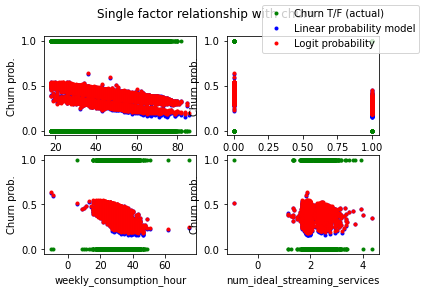

In [633]:
# Evaluate model predictions on test set graphically
df_test_basic['prob_churn_lpm'] = lpm_results.predict(df_test_basic[x_col_name])
df_test_basic['prob_churn_logit'] = logit_results.predict(df_test_basic[x_col_name])

# plot predictions vs. data
select_plot_coef = [x for x in x_col_name if x != 'const']
n_rows = 2
n_cols = math.ceil(len(select_plot_coef) / n_rows)
fig, axes = plt.subplots(n_rows, n_cols)
fig.suptitle('Single factor relationship with churn')
for i in range(n_rows):
    for j in range(n_cols):
        select_coef = select_plot_coef[i * n_cols + j]
        print(select_coef)
        axes[i, j].plot(df_test_basic[select_coef], df_test_basic['churn'],"g.")
        axes[i, j].plot(df_test_basic[select_coef], df_test_basic['prob_churn_lpm'], 'b.')
        axes[i, j].plot(df_test_basic[select_coef], df_test_basic['prob_churn_logit'], 'r.')
        axes[i, j].set(xlabel=select_coef, ylabel='Churn prob.')
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

We can tell that males are more likely to churn.<br>
Users who are older are more likely to churn. <br>
Users with higher weekly_consumption_hour is more likely to churn.

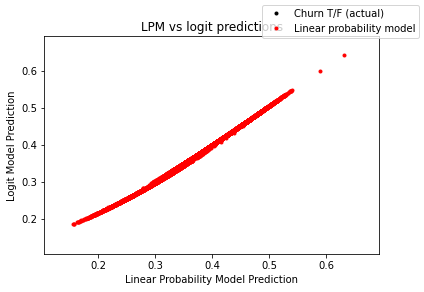

In [634]:
# Compare lpm and logit predictions
fig = plt.figure()
ax = plt.gca()
ax.plot(df_test_basic[['prob_churn_lpm']], df_test_basic[['churn']], 'k.')
ax.plot(df_test_basic[['prob_churn_lpm']], df_test_basic[['prob_churn_logit']], 'r.')
plt.ylim(df_test_basic[['prob_churn_lpm', 'prob_churn_logit']].min().min()-.05, df_test_basic[['prob_churn_lpm', 'prob_churn_logit']].max().max()+.05)
plt.xlim(ax.get_ylim())
plt.title('LPM vs logit predictions')
plt.xlabel('Linear Probability Model Prediction')
plt.ylabel('Logit Model Prediction')
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

We can see that the results of lpm and logit models are very similar.

In [635]:
def get_gini_info(actual, pred_prob):
    # format[[obs0_pred0, obs0_pred1], [obs1_pred0, obs1_pred1]]; rows (i) are observed, columns (j) are predicted
    confusion_matrix_list = list()
    for t in [x / 100 for x in range(0, 100, 33)]:
        pred = [1 if (x > t) else 0 for x in pred_prob]
        confusion_matrix_list.append(confusion_matrix(actual, pred))
        # confusion_matrix_list.append(model.pred_table(threshold=t))

    # create Gini coefficient plots
    false_positives = list()
    true_positives = list()
    for t in confusion_matrix_list:
        true_positives.append(t[1, 1])
        false_positives.append(t[0, 1])

    return confusion_matrix_list, false_positives, true_positives

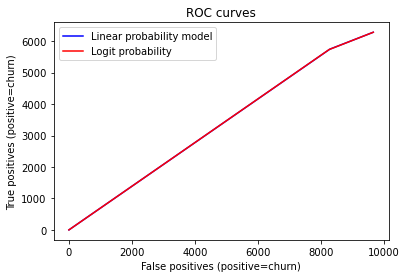

In [636]:
# Ealuate model predictions using numerical quantification (ROC curves)
# make confusion matrices
logit_conf_mat, logit_false_positives, logit_true_positives = get_gini_info(df_test_basic['churn'], df_test_basic['prob_churn_logit'])
lpm_conf_mat, lpm_false_positives, lpm_true_positives = get_gini_info(df_test_basic['churn'], df_test_basic['prob_churn_lpm'])

# plot ROC curves
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(lpm_false_positives, lpm_true_positives, 'b')
ax1.plot(logit_false_positives, logit_true_positives, 'r')
plt.title('ROC curves')
plt.xlabel('False positives (positive=churn)')
plt.ylabel('True positives (positive=churn)')
plt.legend(labels=['Linear probability model', 'Logit probability'])

We can see that ROC for both models are very poor.

In [637]:
df_churn

,subid,churn,last_payment,gender,age,weekly_consumption_hour,num_ideal_streaming_services
0,20000604,0,2020-02-24 11:05:23,0,47.96371,28.589876,1.998926
1,20000685,0,2020-03-18 14:33:41,0,67.00000,25.851492,1.873939
2,20000796,1,2019-10-10 13:35:38,0,34.00000,22.951579,1.842170
3,20000809,0,2020-03-27 19:12:33,0,41.00000,22.951579,1.901712
4,20001112,1,2019-09-28 13:50:51,0,47.96371,28.589876,1.998926
...,...,...,...,...,...,...,...
53170,29999052,0,2020-03-08 11:05:23,1,47.96371,28.589876,1.998926
53171,29999206,0,2020-01-21 11:05:25,0,47.96371,28.589876,1.998926
53172,29999590,0,2020-02-04 13:46:42,0,38.00000,28.751405,1.961446
53173,29999889,1,2020-01-07 13:56:28,0,47.96371,28.589876,1.998926


This indicates that we need additional information for better models from the engagement data.

In [435]:
df_eng.reset_index(drop = True, inplace = True)

In [452]:
# Write filtered data from df_eng to csv file

if 1 == 0:
    idx_eng = [i for i in df_eng.index if df_eng.loc[i]['subid'] in id_joint]
    df_eng_joint = df_eng.loc[idx_eng]
    df_eng_joint.to_csv('df_eng_joint.csv', index = False)

df_eng_joint = pd.read_csv('df_eng_joint.csv')

In [465]:
print('Here we discover that the original representative dataset had {} records for {} differet users.'.format(len(df_eng),len(df_eng['subid'].unique())))
print('The filtered representative dataset had {} records for {} differet users.'.format(len(df_eng_joint),len(df_eng_joint['subid'].unique())))
print('This might indicate that the majority of engagement records are for the 53175 users that we are interested in.\nThe remaining records belong to those who have not finished trial.')

Here we discover that the original representative dataset had 2585724 records for 135019 differet users.
The filtered representative dataset had 2057912 records for 53175 differet users.
This might indicate that the majority of engagement records are for the 53175 users that we are interested in.
The remaining records belong to those who have not finished trial.


In [467]:
df_eng_grp = df_eng_joint.groupby('subid')

In [568]:
# Build a function that get the engagement information for each user we are interested in

def get_engagement(subid):
    
    '''
    The input of the function is the subid representing each user.
    The output of the function is a list of engagement information for the lastest month.
    '''
    
    df_user = df_eng_grp.get_group(subid)
    df_user.reset_index(drop = True, inplace = True)
    
    last_date = df_user.iloc[-1]['date']
    year, month, day = last_date.split('-')
    start_month = str(int(month) - 1).zfill(2)
    start_date = '-'.join([year, start_month, day])
    
    # find the functions that 
    df_latest = df_user[df_user['date'] > start_date]
    df_latest = df_latest.drop(columns = ['subid', 'date', 'payment_period'])
    eng_info = df_latest.apply(sum, axis = 0)
    eng_info['num_day_active'] = len(df_latest)
    
    return list(eng_info)

In [569]:
# Use the function to get the info we want from df_eng_joint and store them in a dataframe

if 1 == 0:
    info_act = [get_engagement(subid) for subid in id_joint]
    col_names = ['app_opens','cust_service_mssgs','num_videos_completed','num_videos_more_than_30_seconds','num_videos_rated','num_series_started','num_day_active']
    df_act = pd.DataFrame(info_act, columns = col_names)

In [639]:
# Impute missing values and save dataframe in csv file

if 1 == 0:
    df_act_imp = pd.DataFrame(imp.fit_transform(df_act))
    df_act_imp.columns = col_names
    df_final = pd.concat([df_churn, df_act_imp], axis = 1)
    df_final.to_csv('df_final.csv', index = False)
    
df_final = pd.read_csv('df_final.csv')

In [642]:
df_final

,subid,churn,last_payment,gender,age,weekly_consumption_hour,num_ideal_streaming_services,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,num_day_active
0,20000604,0,2020-02-24 11:05:23,0,47.96371,28.589876,1.998926,14.00000,5.000000,8.000000,68.000000,0.000000,1.000000,15.0
1,20000685,0,2020-03-18 14:33:41,0,67.00000,25.851492,1.873939,30.00000,7.000000,3.000000,112.000000,0.000000,1.000000,27.0
2,20000796,1,2019-10-10 13:35:38,0,34.00000,22.951579,1.842170,144.00000,10.000000,127.000000,131.000000,2.000000,28.000000,31.0
3,20000809,0,2020-03-27 19:12:33,0,41.00000,22.951579,1.901712,45.10261,5.356508,47.426441,83.472151,1.733341,14.038263,6.0
4,20001112,1,2019-09-28 13:50:51,0,47.96371,28.589876,1.998926,11.00000,1.000000,1.000000,77.000000,0.000000,13.000000,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53170,29999052,0,2020-03-08 11:05:23,1,47.96371,28.589876,1.998926,4.00000,2.000000,2.000000,33.000000,0.000000,0.000000,6.0
53171,29999206,0,2020-01-21 11:05:25,0,47.96371,28.589876,1.998926,176.00000,7.000000,132.000000,132.000000,1.000000,31.000000,31.0
53172,29999590,0,2020-02-04 13:46:42,0,38.00000,28.751405,1.961446,50.00000,2.000000,11.000000,87.000000,0.000000,14.000000,22.0
53173,29999889,1,2020-01-07 13:56:28,0,47.96371,28.589876,1.998926,74.00000,16.000000,124.000000,124.000000,20.000000,31.000000,31.0


Now we have all the information we need for modeling.

In [657]:
# Split the dataset and preprocess for model fitting 

df_train, df_test = model_selection.train_test_split(df_final, test_size=0.3)

y_col_name = 'churn'
x_col_name = ['age','gender','weekly_consumption_hour','num_ideal_streaming_services'] + col_names
add_constant_TF = True

if add_constant_TF:
    x_col_name.append('const')
    df_train = sm.add_constant(df_train)
    df_test = sm.add_constant(df_test)

In [659]:
# Fit linear probability model
lpm_model = sm.OLS(endog=df_train[y_col_name], exog=df_train[x_col_name])
lpm_results = lpm_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(lpm_results.summary())

# Fit logistic regression model
logit_model = sm.Logit(endog=df_train[y_col_name], exog=df_train[x_col_name])
logit_results = logit_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(logit_results.summary())


RESULTS OF LOGIT MODEL FITTING

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     72.81
Date:                Fri, 10 Dec 2021   Prob (F-statistic):          7.59e-163
Time:                        23:34:08   Log-Likelihood:                -25760.
No. Observations:               37222   AIC:                         5.154e+04
Df Residuals:                   37210   BIC:                         5.165e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

Next we use VIF to choose variable to drop.

In [653]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [660]:
x_temp = sm.add_constant(df_train[x_col_name])

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.values.shape[1])]
vif["features"] = x_temp.columns
print(vif.round(1))

    VIF Factor                         features
0          1.0                              age
1          1.4                           gender
2          1.4          weekly_consumption_hour
3          1.0     num_ideal_streaming_services
4          1.6                        app_opens
5          1.6               cust_service_mssgs
6          3.8             num_videos_completed
7         12.2  num_videos_more_than_30_seconds
8          1.3                 num_videos_rated
9          5.6               num_series_started
10         9.1                   num_day_active
11       220.4                            const


Since variable ***num_videos_more_than_30_seconds*** has the highest VIF, we drop it.

In [731]:
# Drop the variables and train a new model

df_model = df_final.drop(columns = 'num_videos_more_than_30_seconds')

df_train, df_test = model_selection.train_test_split(df_model, test_size=0.3)

y_col_name = 'churn'
x_col_name = ['age','gender','weekly_consumption_hour','num_ideal_streaming_services'] + col_names
x_col_name.remove('num_videos_more_than_30_seconds')
x_col_name.remove('num_videos_completed')
x_col_name.remove('num_videos_rated')
x_col_name.remove('num_ideal_streaming_services')
add_constant_TF = True

if add_constant_TF:
    x_col_name.append('const')
    df_train = sm.add_constant(df_train)
    df_test = sm.add_constant(df_test)

Let's train a new model.

In [809]:
# Fit linear probability model
lpm_model = sm.OLS(endog=df_train[y_col_name], exog=df_train[x_col_name])
lpm_results = lpm_model.fit()
print("\nRESULTS OF LPM MODEL FITTING\n")
print(lpm_results.summary())

# Fit logistic regression model
logit_model = sm.Logit(endog=df_train[y_col_name], exog=df_train[x_col_name])
logit_results = logit_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(logit_results.summary())


RESULTS OF LPM MODEL FITTING

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     98.31
Date:                Sat, 11 Dec 2021   Prob (F-statistic):          5.42e-143
Time:                        17:47:56   Log-Likelihood:                -25831.
No. Observations:               37222   AIC:                         5.168e+04
Df Residuals:                   37214   BIC:                         5.175e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

age
gender
weekly_consumption_hour
app_opens
cust_service_mssgs
num_series_started
num_day_active


IndexError: list index out of range

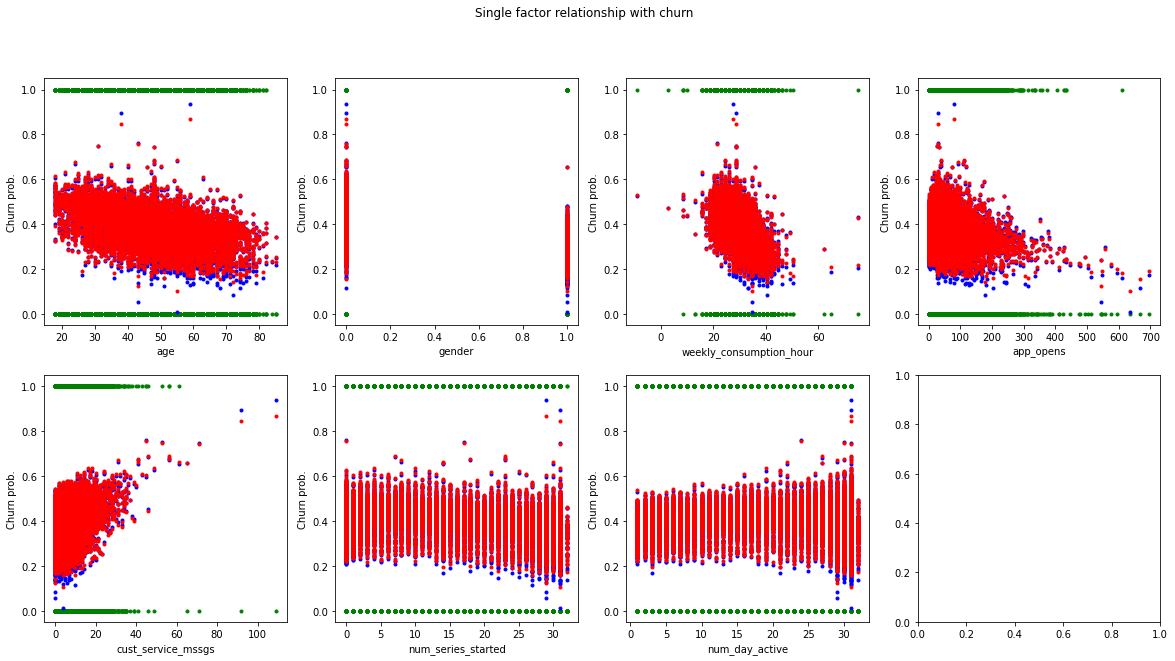

In [742]:
# Evaluate model predictions on test set graphically
df_test['prob_churn_lpm'] = lpm_results.predict(df_test[x_col_name])
df_test['prob_churn_logit'] = logit_results.predict(df_test[x_col_name])

# plot predictions vs. data
select_plot_coef = [x for x in x_col_name if x != 'const']
n_rows = 2
n_cols = math.ceil(len(select_plot_coef) / n_rows)
fig, axes = plt.subplots(n_rows, n_cols ,figsize=(20,10))
fig.suptitle('Single factor relationship with churn')
for i in range(n_rows):
    for j in range(n_cols):
        select_coef = select_plot_coef[i * n_cols + j]
        print(select_coef)
        axes[i, j].plot(df_test[select_coef], df_test['churn'],"g.")
        axes[i, j].plot(df_test[select_coef], df_test['prob_churn_lpm'], 'b.')
        axes[i, j].plot(df_test[select_coef], df_test['prob_churn_logit'], 'r.')
        axes[i, j].set(xlabel=select_coef, ylabel='Churn prob.')
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

We can see that: <br>
Users who are older are more likely to churn.<br>
Males users are more likely to churn.<br>
Users with higher weekly consumption hour are more likely to churn.<br>
Users who opened apps less are more likely to churn.<br>
Users who sent more customer service messages are more likely to churn.

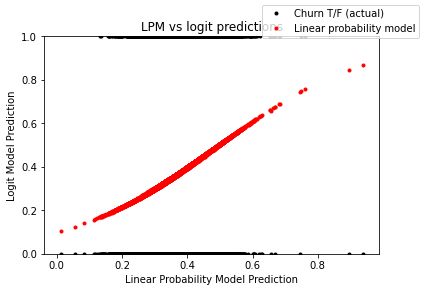

In [748]:
# Compare lpm and logit predictions
fig = plt.figure()
ax = plt.gca()
ax.plot(df_test[['prob_churn_lpm']], df_test[['churn']], 'k.')
ax.plot(df_test[['prob_churn_lpm']], df_test[['prob_churn_logit']], 'r.')
plt.ylim(df_test[['prob_churn_lpm', 'prob_churn_logit']].min().min()-.05, df_test[['prob_churn_lpm', 'prob_churn_logit']].max().max()+.05)
plt.xlim(ax.get_ylim())
plt.title('LPM vs logit predictions')
plt.xlabel('Linear Probability Model Prediction')
plt.ylabel('Logit Model Prediction')
plt.ylim((0,1))
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

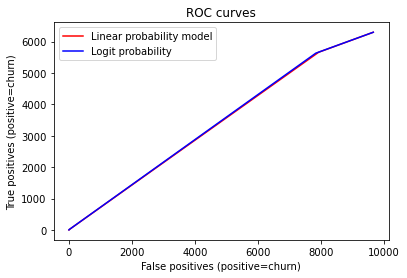

In [749]:
# --- evaluate model predictions using numerical quantification (ROC curves)
# make confusion matrices
logit_conf_mat, logit_false_positives, logit_true_positives = get_gini_info(df_test['churn'], df_test['prob_churn_logit'])
lpm_conf_mat, lpm_false_positives, lpm_true_positives = get_gini_info(df_test['churn'], df_test['prob_churn_lpm'])

# plot ROC curves
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(lpm_false_positives, lpm_true_positives, 'r')
ax1.plot(logit_false_positives, logit_true_positives, 'b')
plt.title('ROC curves')
plt.xlabel('False positives (positive=churn)')
plt.ylabel('True positives (positive=churn)')
plt.legend(labels=['Linear probability model', 'Logit probability'])

Next, we can test retention offer scenarios.

In [756]:
# Build the apply_offer function

def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f['churn'] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['churn'] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['churn'] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance

    # make offer under lpm predictions for select threshold
    df_f['make_offer_lpm'] = (df_f['prob_churn_lpm'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_lpm'] = (df_f['make_offer_lpm'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_lpm_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_lpm'], 'price_lpm_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    # make offer under logit predictions for select threshold
    df_f['make_offer_logit'] = (df_f['prob_churn_logit'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_logit'] = (df_f['make_offer_logit'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_logit_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_logit'], 'price_logit_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact

In [754]:
df_convert_joint['monthly_price'].value_counts()

4.7343    53053
5.1013       84
1.0643       26
4.4407        7
4.3673        4
4.0003        1
Name: monthly_price, dtype: int64

In [763]:
df_convert_joint['discount_price'].value_counts()

4.5141    53052
5.0279       84
1.0276       26
4.2205        7
4.0737        4
4.4407        1
3.7801        1
Name: discount_price, dtype: int64

In [762]:
df_convert_joint['discount_price'].value_counts().index[0]/df_convert_joint['monthly_price'].value_counts().index[0]

0.9534883720930232

Since majority of users had the same plan, we set the base price to 4.73.<br>
And we set our default discount to 0.05.

In [764]:
# Evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.3
threshold = 0.5
base_price = 4.73
discount_amount = 0.05
cases = ['no_offer', 'lpm_offer', 'logit_offer']

# draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
df_test['random_draws'] = np.random.random(df_test.shape[0])

# base assessment
df_test, df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)


# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

# test sensitivity to acceptance rate for churners
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind

# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind

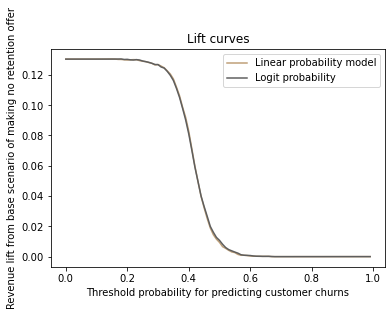

In [765]:
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.3
threshold = 0.5
base_price = 4.73
discount_amount = 0.05
cases = ['no_offer', 'lpm_offer', 'logit_offer']

# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

# Threshold sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['lpm_offer'], color = '#be9f77')
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], color = '#5e5e5e')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

In [772]:
df_lift_threshold[df_lift_threshold['lpm_offer'] == df_lift_threshold['lpm_offer'].max()]

,threshold,no_offer,lpm_offer,logit_offer
15,0.15,0.0,0.130474,0.130392


Our sensitivity test implies that, given our current plan price and discount, setting the threshold to 0.15 gives us the highest revenue lift.

Next, let's see if there is a better pricing strategy.

In [776]:
# Build a function that test the sensitivity of threshold given discount and accceptance rate

def get_best_return(threshold = 0.5, method = 'equivalent'):

    # evaluate the impact of an offer
    acceptance_rate_nonchurn = 1
    acceptance_rate_churn = 0.3
    #threshold = 0.50
    base_price = 4.73
    discount_amount = 0.05
    cases = ['no_offer', 'lpm_offer', 'logit_offer']

    # test sensitivity to offer discount amount
    df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
    for t_ind in df_lift_discount_amount.index:
        t_discount_amount = t_ind / 100
    
        # Assume a conservative relationship between discount and acceptance rate
        if method == "conservative":
            if t_discount_amount < 0.1:
                t_acceptance_rate_churn = 0
            elif t_discount_amount > 0.1:
                t_acceptance_rate_churn = t_discount_amount - 0.1
        
        # Assume a relationship between discount and acceptance rate that they are always equivalent
        if method == "equivalent":
            t_acceptance_rate_churn = t_discount_amount
                
        # Assume a constance acceptance rate
        if method == "constant":
            if t_discount_amount < 0.1:
                t_acceptance_rate_churn = 0
            elif t_discount_amount > 0.1:
                t_acceptance_rate_churn = 0.3
    
        _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

        df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
        df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
    del t_df_impact, t_discount_amount, t_ind
    
    best_return = df_lift_discount_amount[df_lift_discount_amount['lpm_offer'] == df_lift_discount_amount['lpm_offer'].max()]
    
    return best_return

Check our best choice given a conservative scenario.

In [782]:
dict_returns = {}
for i in np.arange(0.0, 1.0, 0.01):
    best_return = get_best_return(threshold = i, method = 'conservative')
    if len(best_return) > 1:
        dict_returns[i] = best_return.iloc[0]
    else:
        dict_returns[i] = best_return

In [783]:
threshold = 0
best_return = 0
for key, value in dict_returns.items():
    ret = float(value['lpm_offer'])
    if ret > best_return:
        best_return = ret
        threshold = key
        
best_return = dict_returns[threshold]
discount = float(best_return['discount_amount'])
acceptance = discount - 0.1
ret = float(best_return['lpm_offer'])
print("With a discount amount of {}, an acceptance rate of {}, and a threshold of {}, we have the best return of {}.".format(discount, acceptance, threshold, ret))

With a discount amount of 0.34, an acceptance rate of 0.24000000000000002, and a threshold of 0.55, we have the best return of 0.00026517505697132293.


In [784]:
best_return

,discount_amount,no_offer,lpm_offer,logit_offer
34,0.34,0.0,0.000265,0.000189


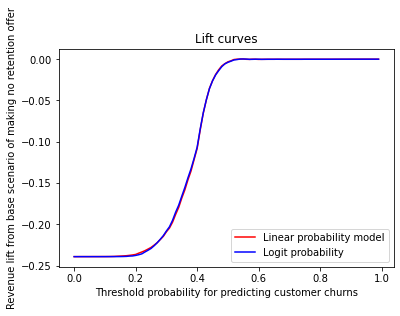

In [811]:
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.24
threshold = 0.55
base_price = 4.73
discount_amount = 0.34
cases = ['no_offer', 'lpm_offer', 'logit_offer']

# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

# Threshold sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['lpm_offer'], 'r')
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], 'b')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

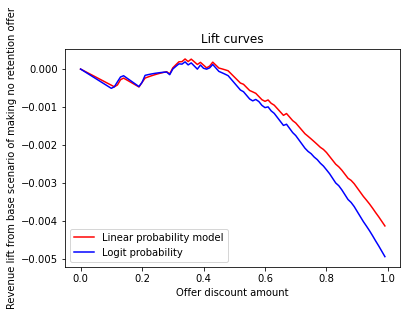

In [810]:
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.3
threshold = 0.55
base_price = 4.73
discount_amount = 0.3
cases = ['no_offer', 'lpm_offer', 'logit_offer']

# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    
    # Build a function that determines the acceptance rate given different discounts
    if t_discount_amount < 0.1:
        t_acceptance_rate_churn = 0
    elif t_discount_amount > 0.1:
        t_acceptance_rate_churn = t_discount_amount - 0.1
    
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind

# Discount amount sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['lpm_offer'], color = 'r')
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], color = 'b')
plt.title('Lift curves')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

Check our best choice given an equivalent scenario.

In [787]:
dict_returns = {}
for i in np.arange(0.0, 1.0, 0.01):
    best_return = get_best_return(threshold = i, method = 'equivalent')
    if len(best_return) > 1:
        dict_returns[i] = best_return.iloc[0]
    else:
        dict_returns[i] = best_return

In [788]:
threshold = 0
best_return = 0
for key, value in dict_returns.items():
    ret = float(value['lpm_offer'])
    if ret > best_return:
        best_return = ret
        threshold = key
        
best_return = dict_returns[threshold]
discount = float(best_return['discount_amount'])
acceptance = discount
ret = float(best_return['lpm_offer'])
print("With a discount amount of {}, an acceptance rate of {}, and a threshold of {}, we have the best return of {}.".format(discount, acceptance, threshold, ret))

With a discount amount of 0.24, an acceptance rate of 0.24, and a threshold of 0.52, we have the best return of 0.0012802983219388775.


In [789]:
best_return

,discount_amount,no_offer,lpm_offer,logit_offer
24,0.24,0.0,0.00128,0.001052


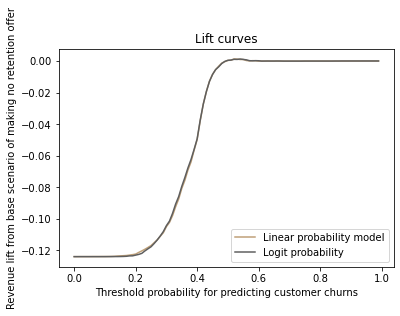

In [790]:
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.24
threshold = 0.52
base_price = 4.73
discount_amount = 0.24
cases = ['no_offer', 'lpm_offer', 'logit_offer']

# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

# Threshold sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['lpm_offer'], color = '#be9f77')
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], color = '#5e5e5e')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

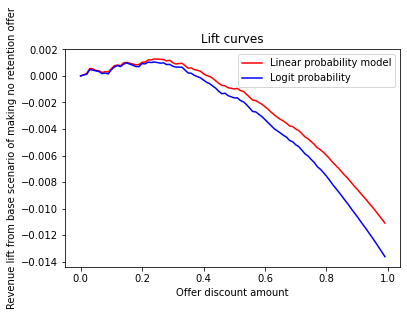

In [812]:
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.24
threshold = 0.52
base_price = 4.73
discount_amount = 0.24
cases = ['no_offer', 'lpm_offer', 'logit_offer']

# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    
    # Build a function that determines the acceptance rate given different discounts
    t_acceptance_rate_churn = t_discount_amount
    
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind

# Discount amount sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['lpm_offer'], color = 'r')
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], color = 'b')
plt.title('Lift curves')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])